<a href="https://colab.research.google.com/github/huy164/IS403.N21.HTTT_Nhom17/blob/master/Temporal_Convolutional_Networks_(TCN)_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.dates as mdates



29/29 [==============================] - 0s 2ms/step
Dataset: walmart_stock_price, Train-Test Ratio = 0.7:0.3
Root Mean Squared Error (RMSE): 1.953
Mean Absolute Percentage Error (MAPE): 17.623
Mean Absolute Error (MAE): 1.469


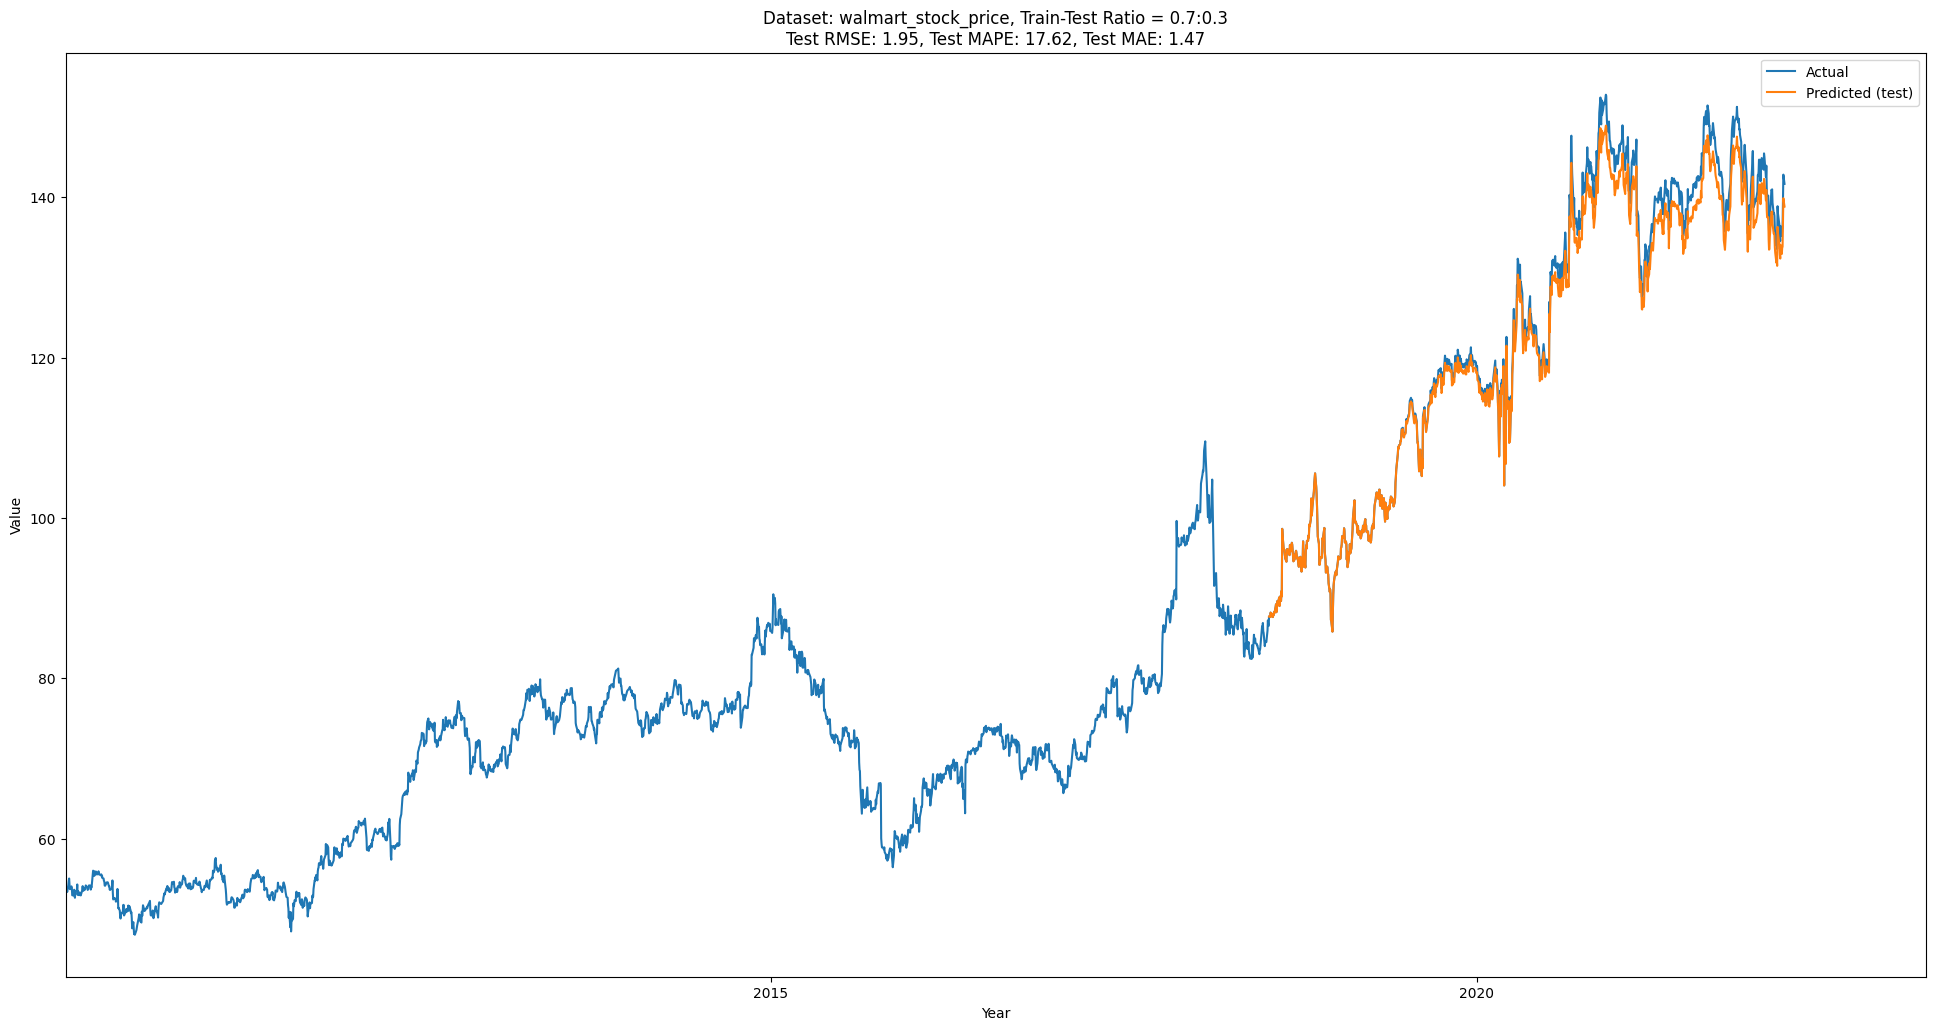



20/20 [==============================] - 0s 2ms/step
Dataset: walmart_stock_price, Train-Test Ratio = 0.8:0.2
Root Mean Squared Error (RMSE): 1.817
Mean Absolute Percentage Error (MAPE): 9.341
Mean Absolute Error (MAE): 1.515


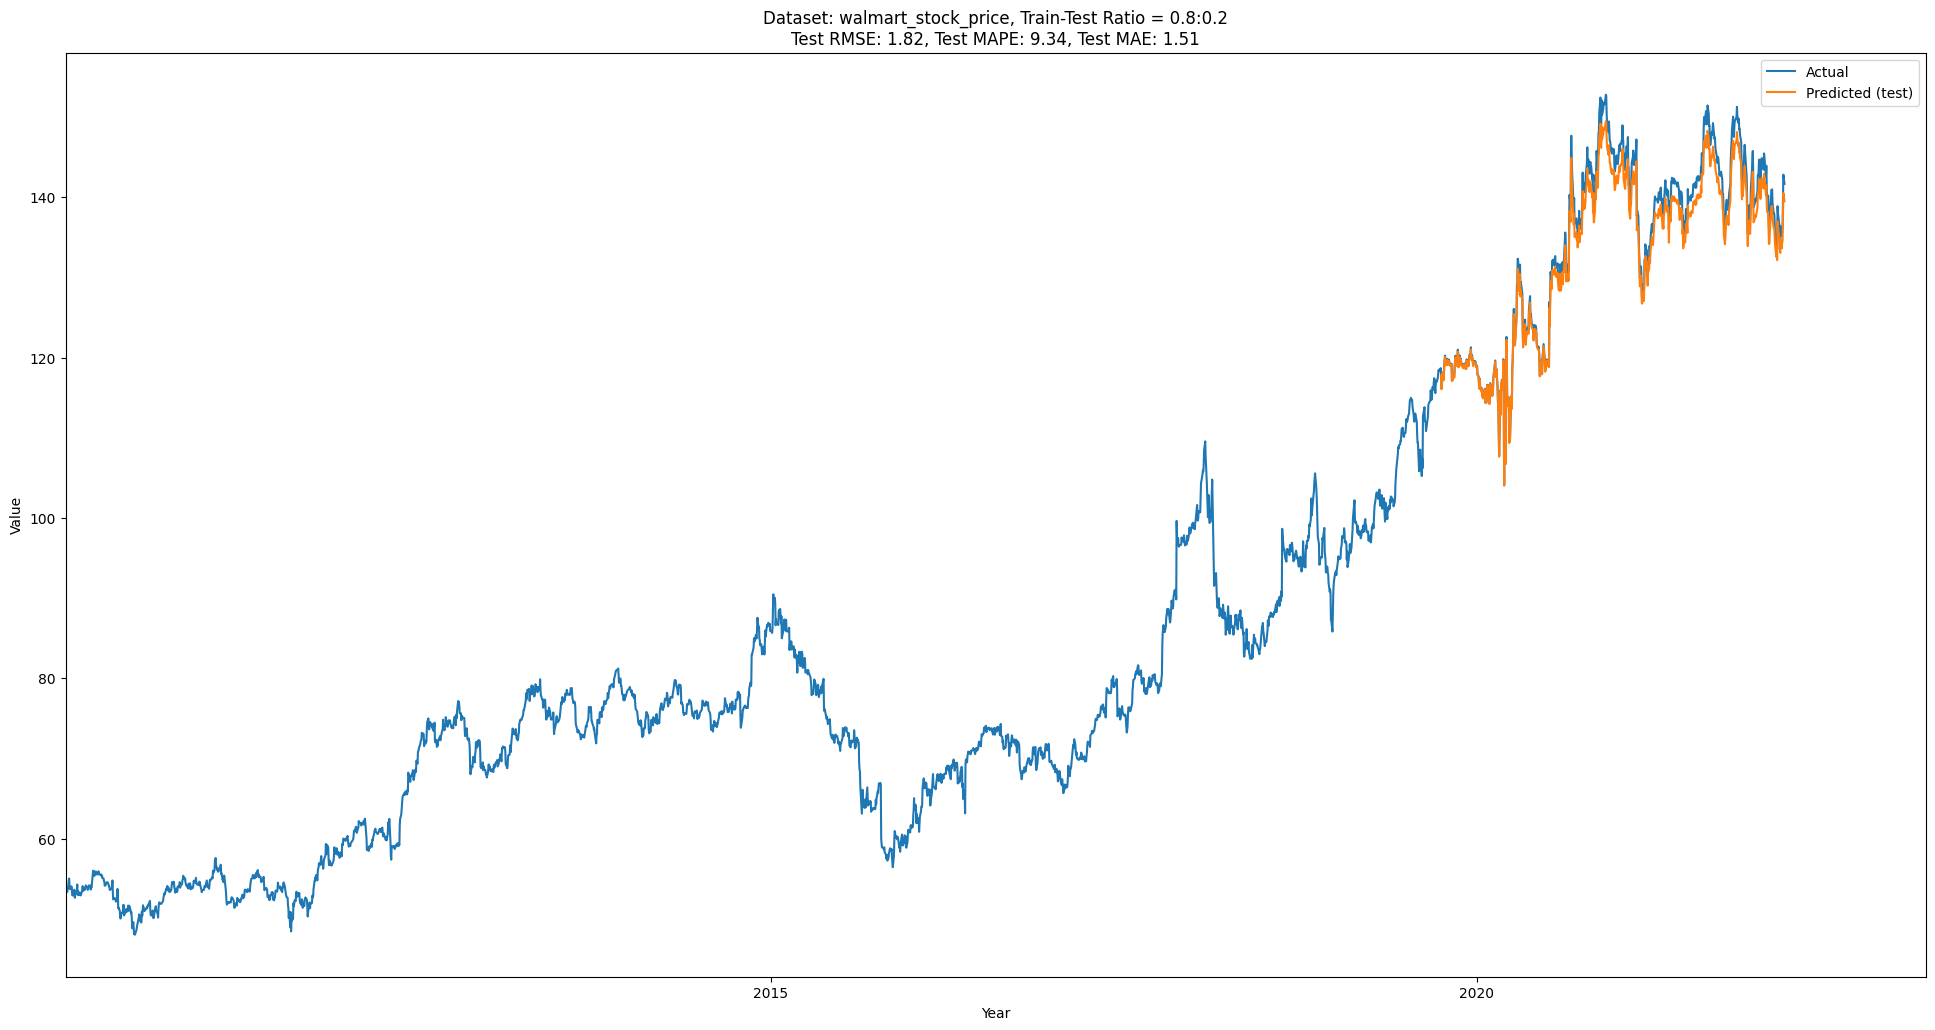



10/10 [==============================] - 0s 3ms/step
Dataset: walmart_stock_price, Train-Test Ratio = 0.9:0.1
Root Mean Squared Error (RMSE): 0.041
Mean Absolute Percentage Error (MAPE): 3.866
Mean Absolute Error (MAE): 0.041


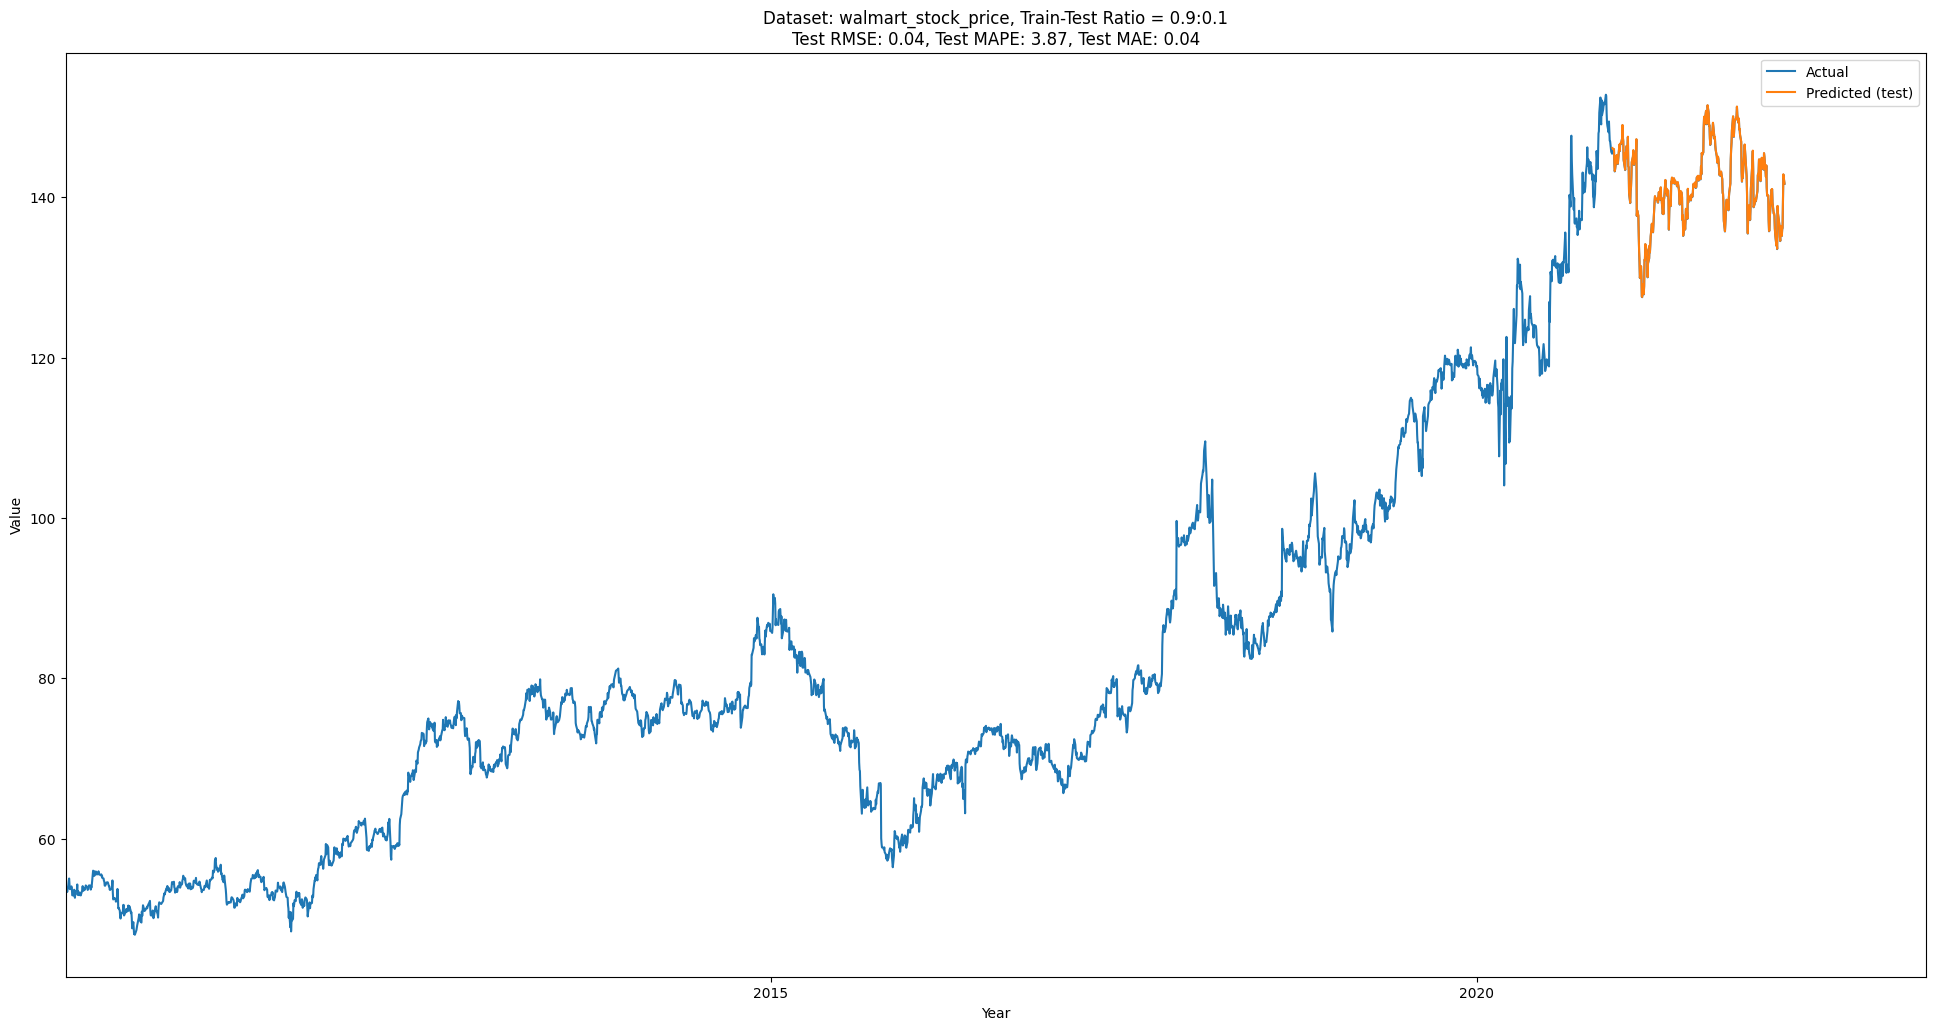



24/24 [==============================] - 0s 2ms/step
Dataset: facebook_stock_price, Train-Test Ratio = 0.7:0.3
Root Mean Squared Error (RMSE): 13.451
Mean Absolute Percentage Error (MAPE): 26.679
Mean Absolute Error (MAE): 9.256


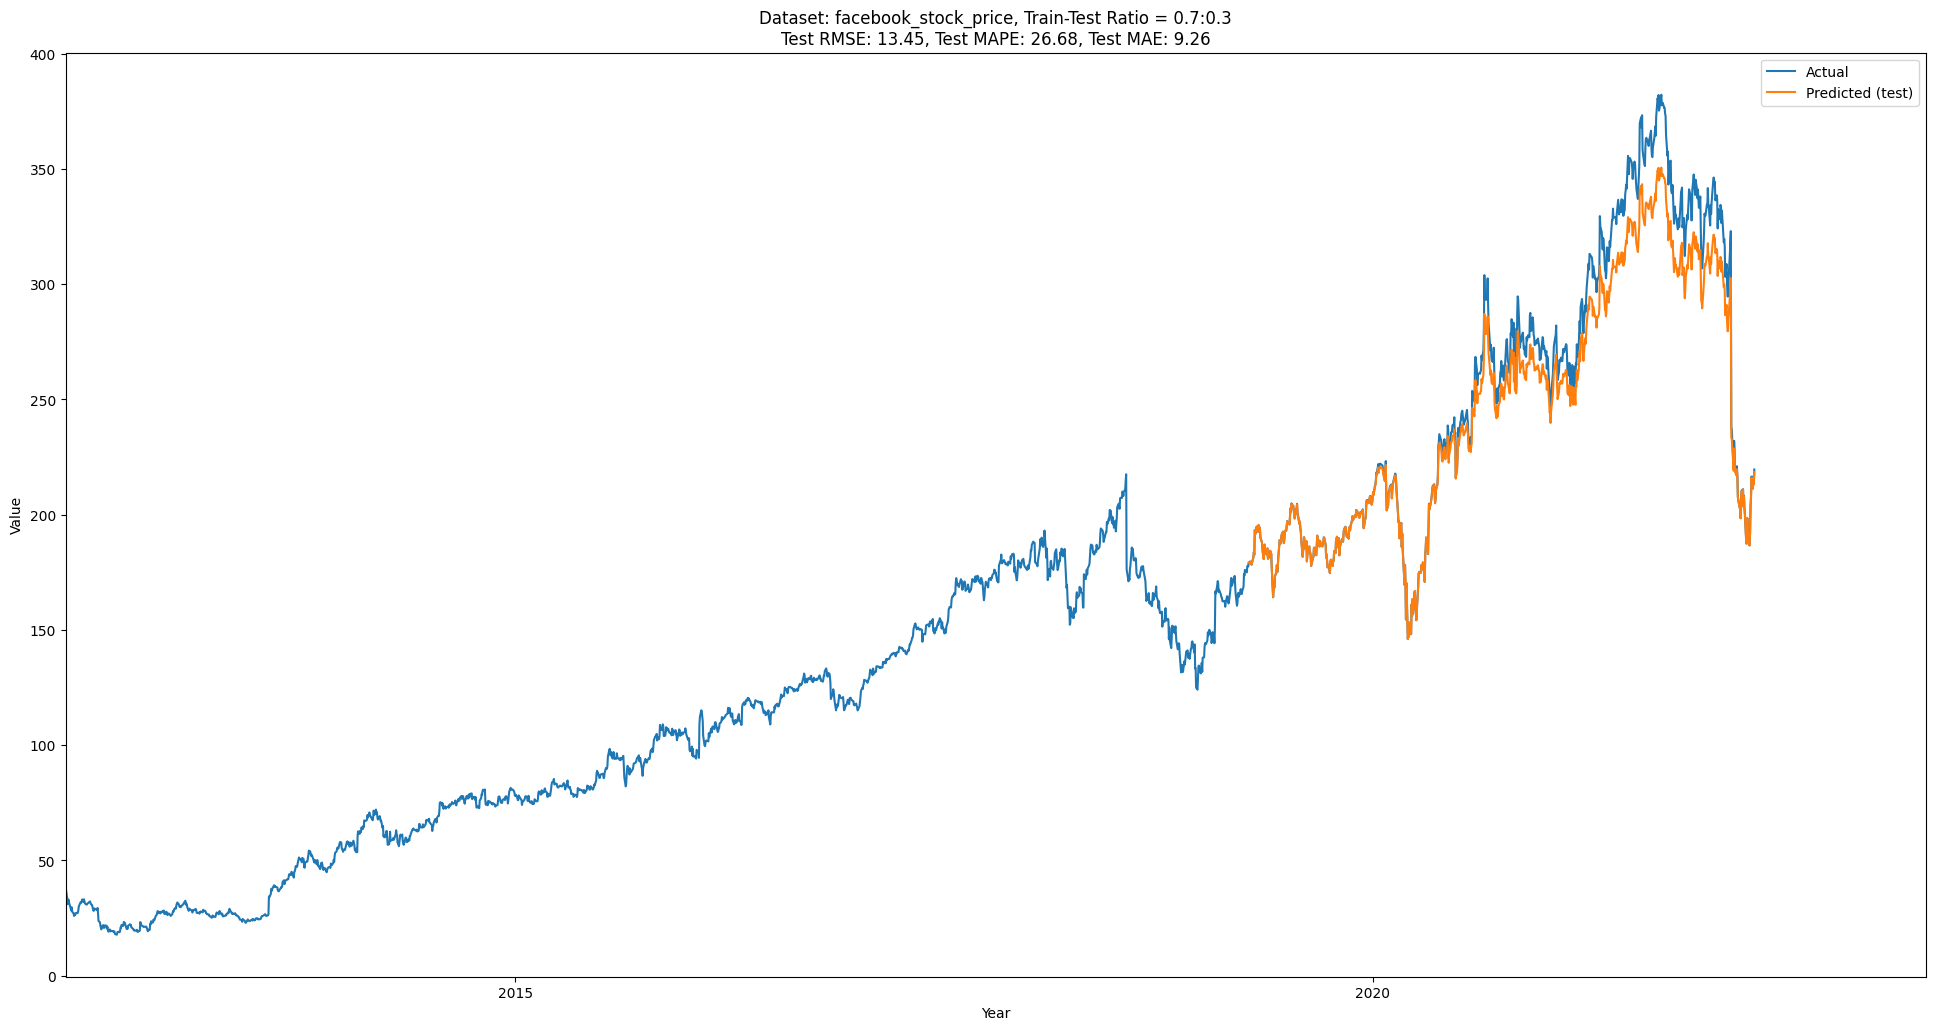



16/16 [==============================] - 0s 2ms/step
Dataset: facebook_stock_price, Train-Test Ratio = 0.8:0.2
Root Mean Squared Error (RMSE): 4.897
Mean Absolute Percentage Error (MAPE): 20.911
Mean Absolute Error (MAE): 4.004


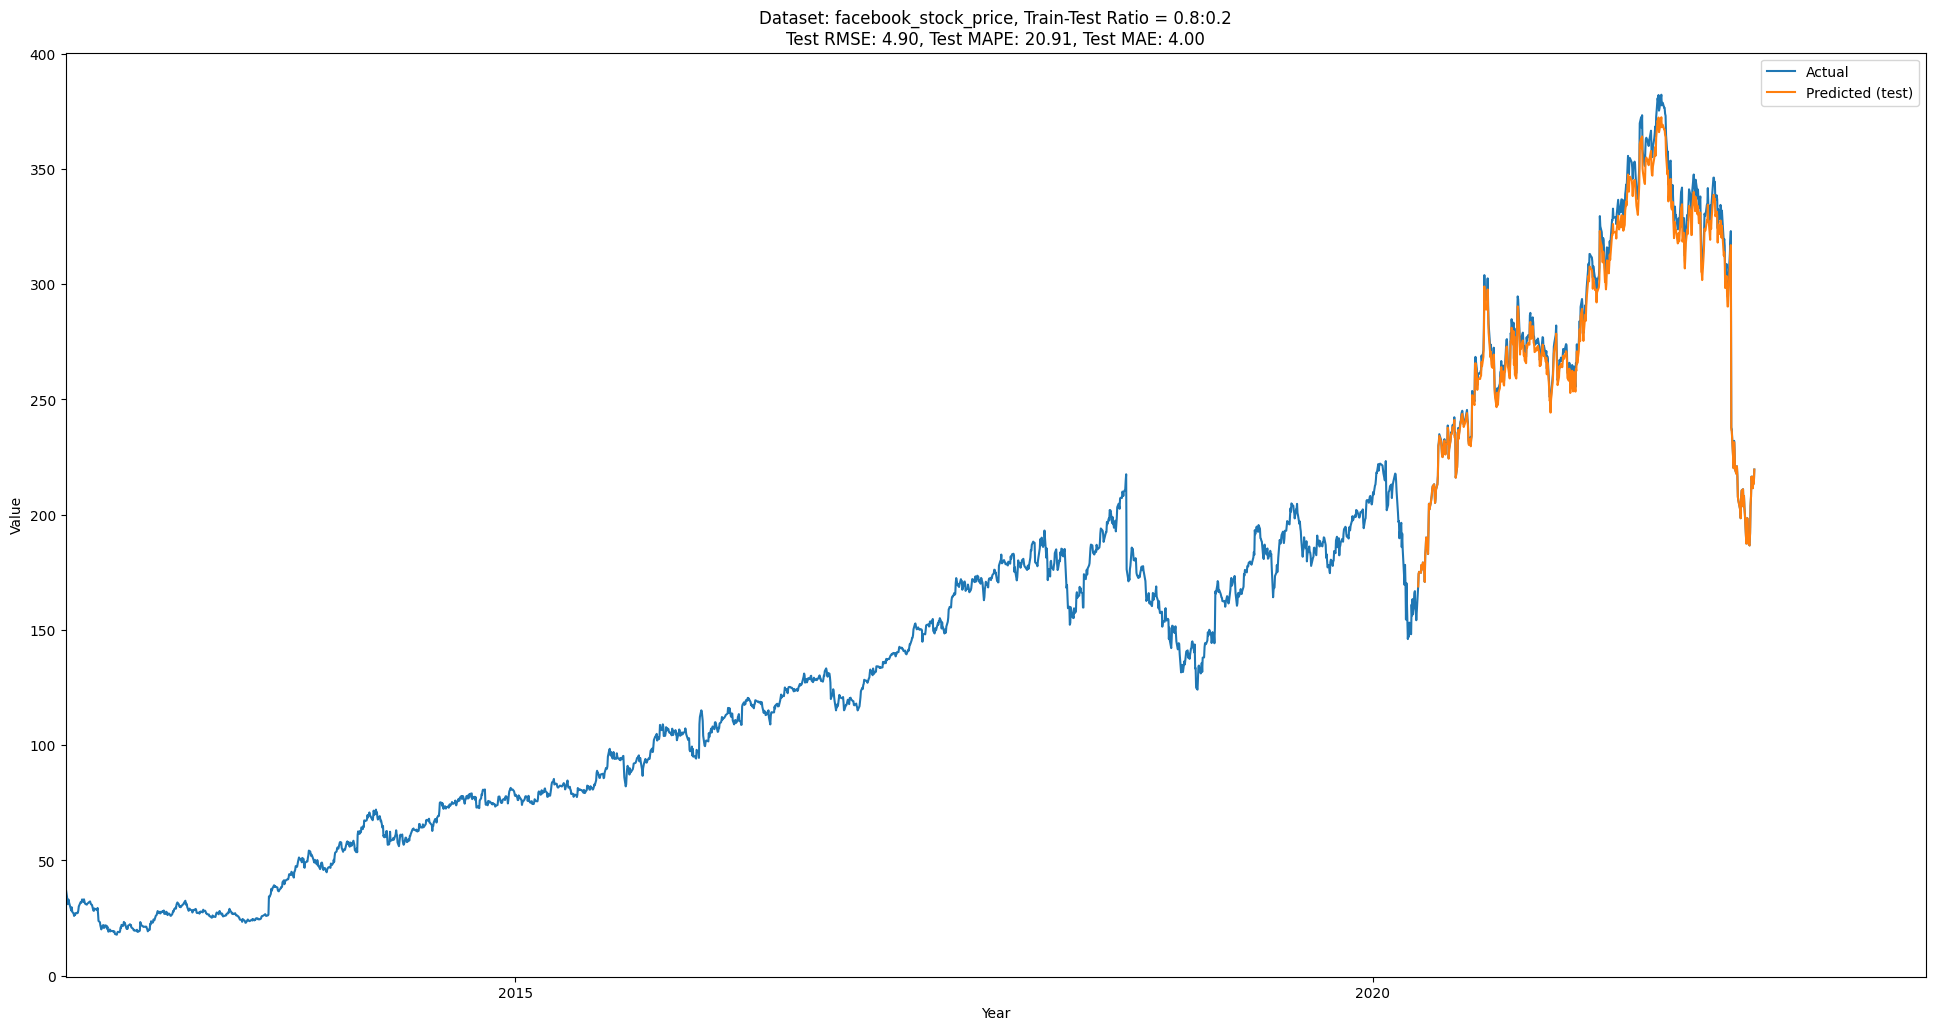



8/8 [==============================] - 0s 3ms/step
Dataset: facebook_stock_price, Train-Test Ratio = 0.9:0.1
Root Mean Squared Error (RMSE): 3.164
Mean Absolute Percentage Error (MAPE): 16.821
Mean Absolute Error (MAE): 2.501


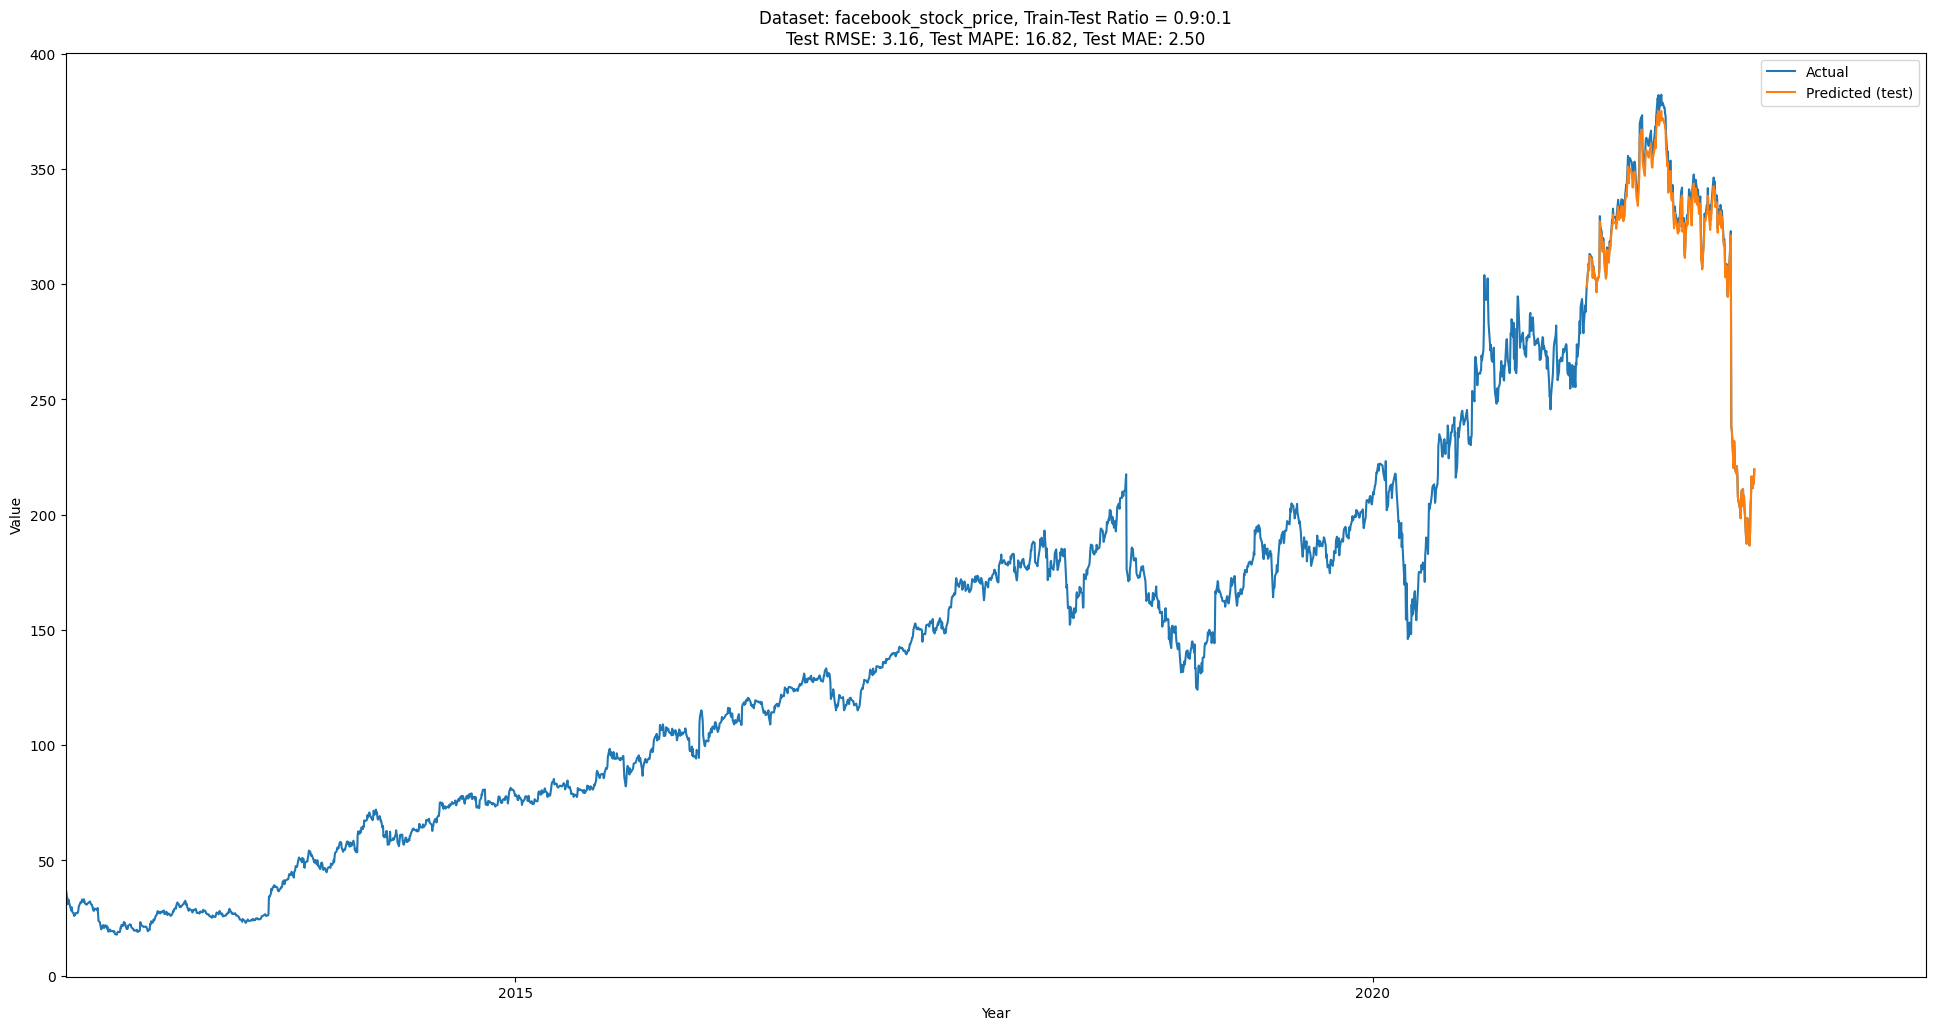



28/28 [==============================] - 0s 2ms/step
Dataset: tesla_stock_price, Train-Test Ratio = 0.7:0.3
Root Mean Squared Error (RMSE): 74.439
Mean Absolute Percentage Error (MAPE): 247.959
Mean Absolute Error (MAE): 50.235


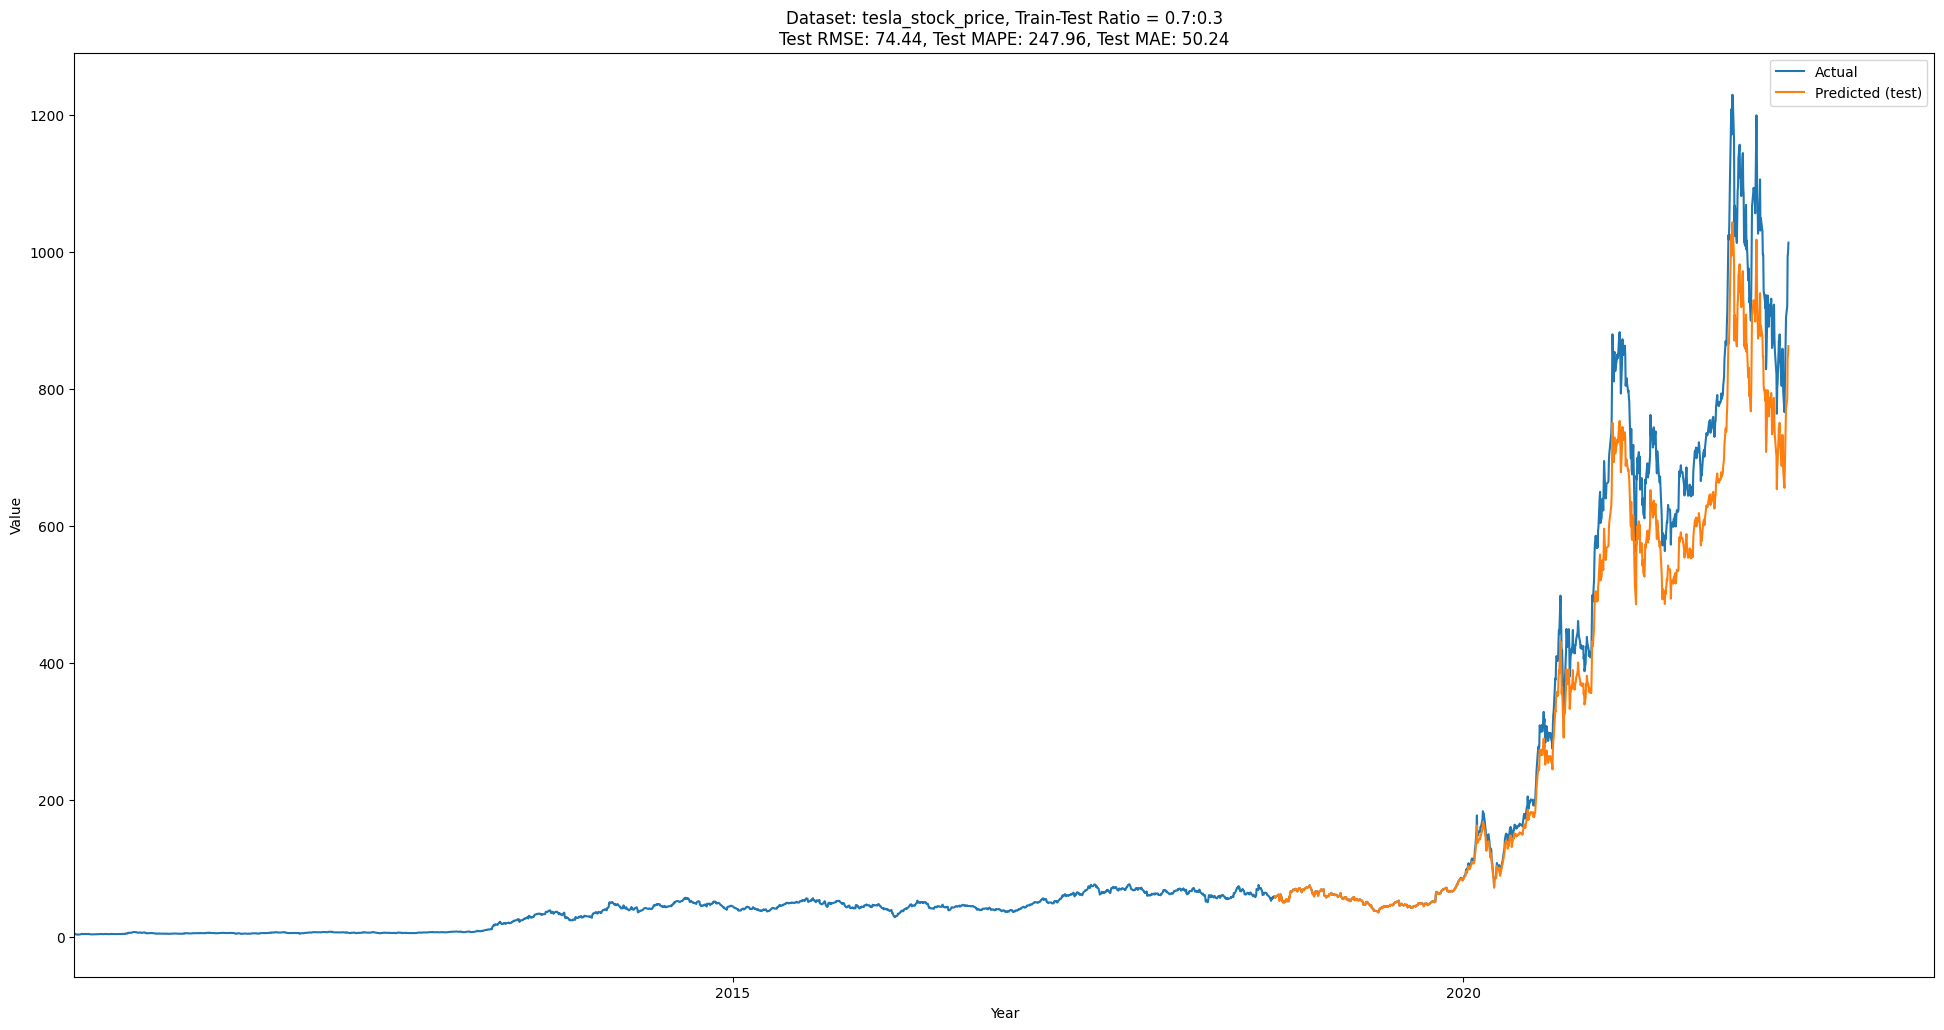



19/19 [==============================] - 0s 3ms/step
Dataset: tesla_stock_price, Train-Test Ratio = 0.8:0.2
Root Mean Squared Error (RMSE): 99.963
Mean Absolute Percentage Error (MAPE): 118.524
Mean Absolute Error (MAE): 82.767


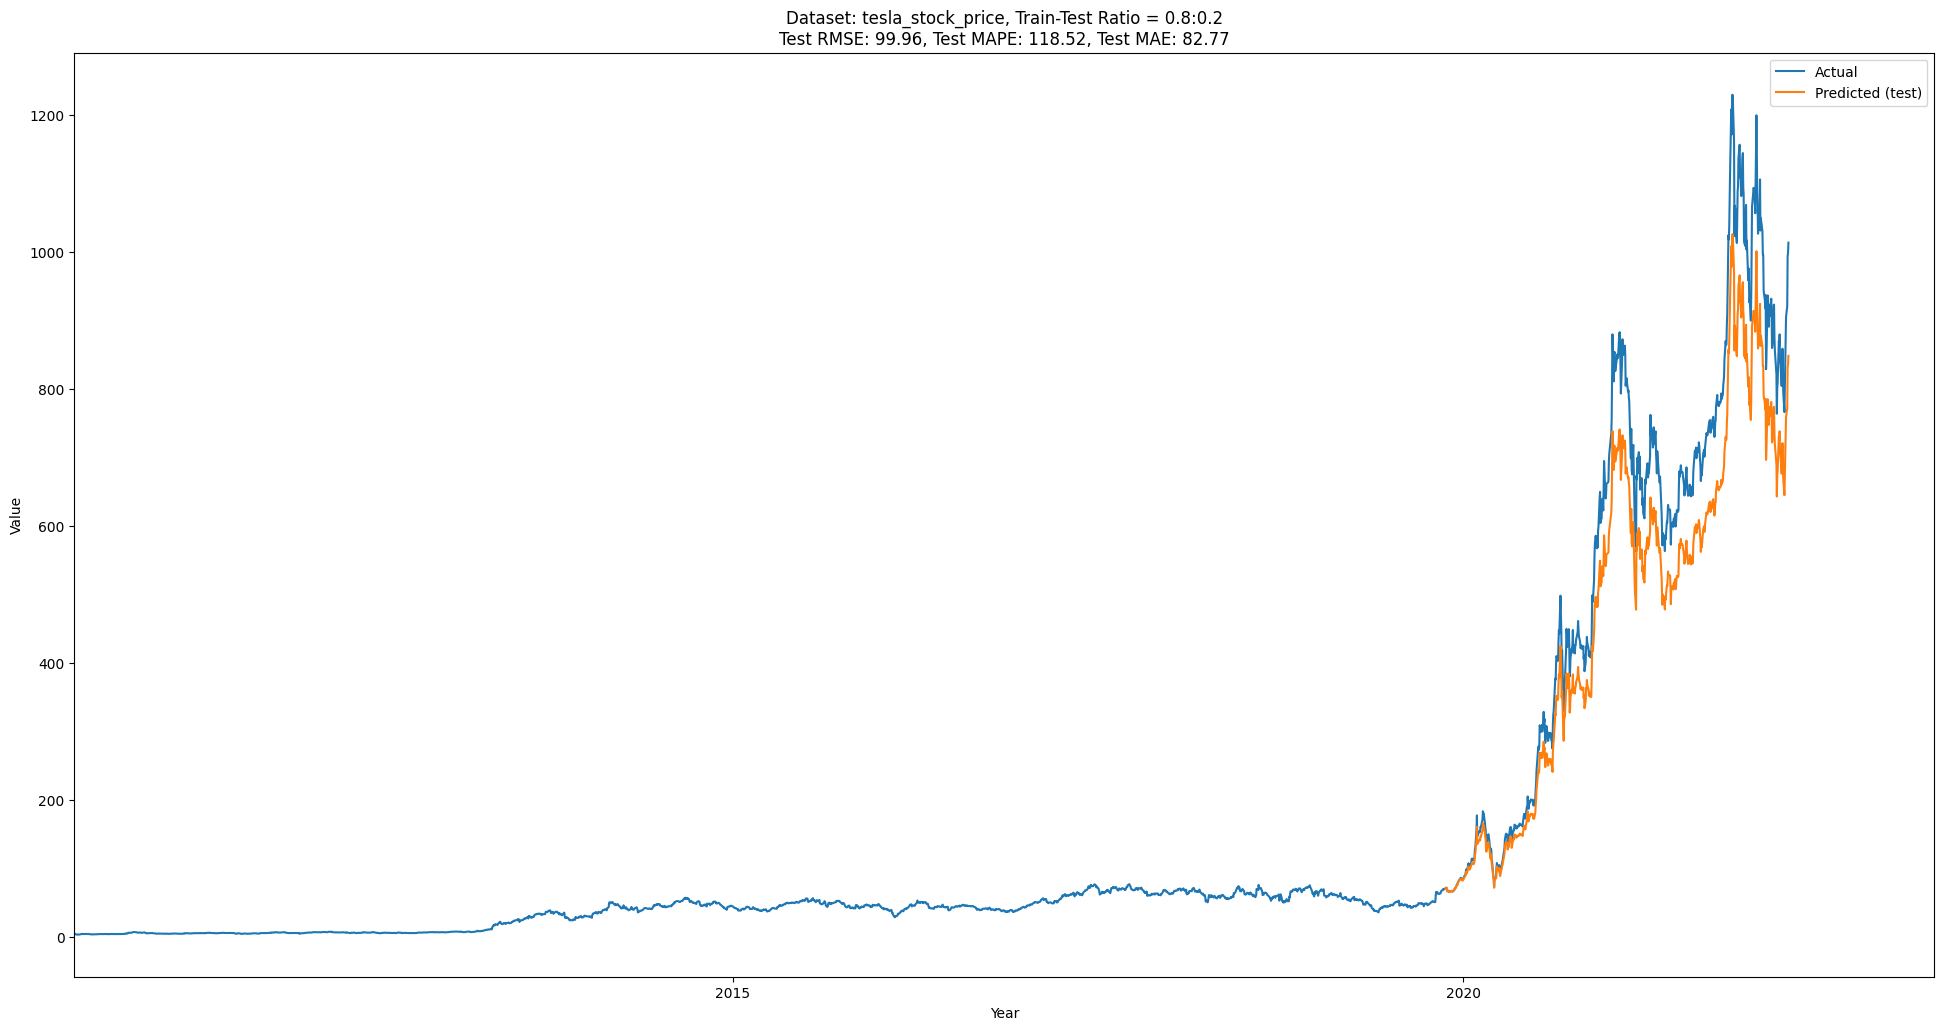



10/10 [==============================] - 0s 3ms/step
Dataset: tesla_stock_price, Train-Test Ratio = 0.9:0.1
Root Mean Squared Error (RMSE): 0.582
Mean Absolute Percentage Error (MAPE): 22.863
Mean Absolute Error (MAE): 0.495


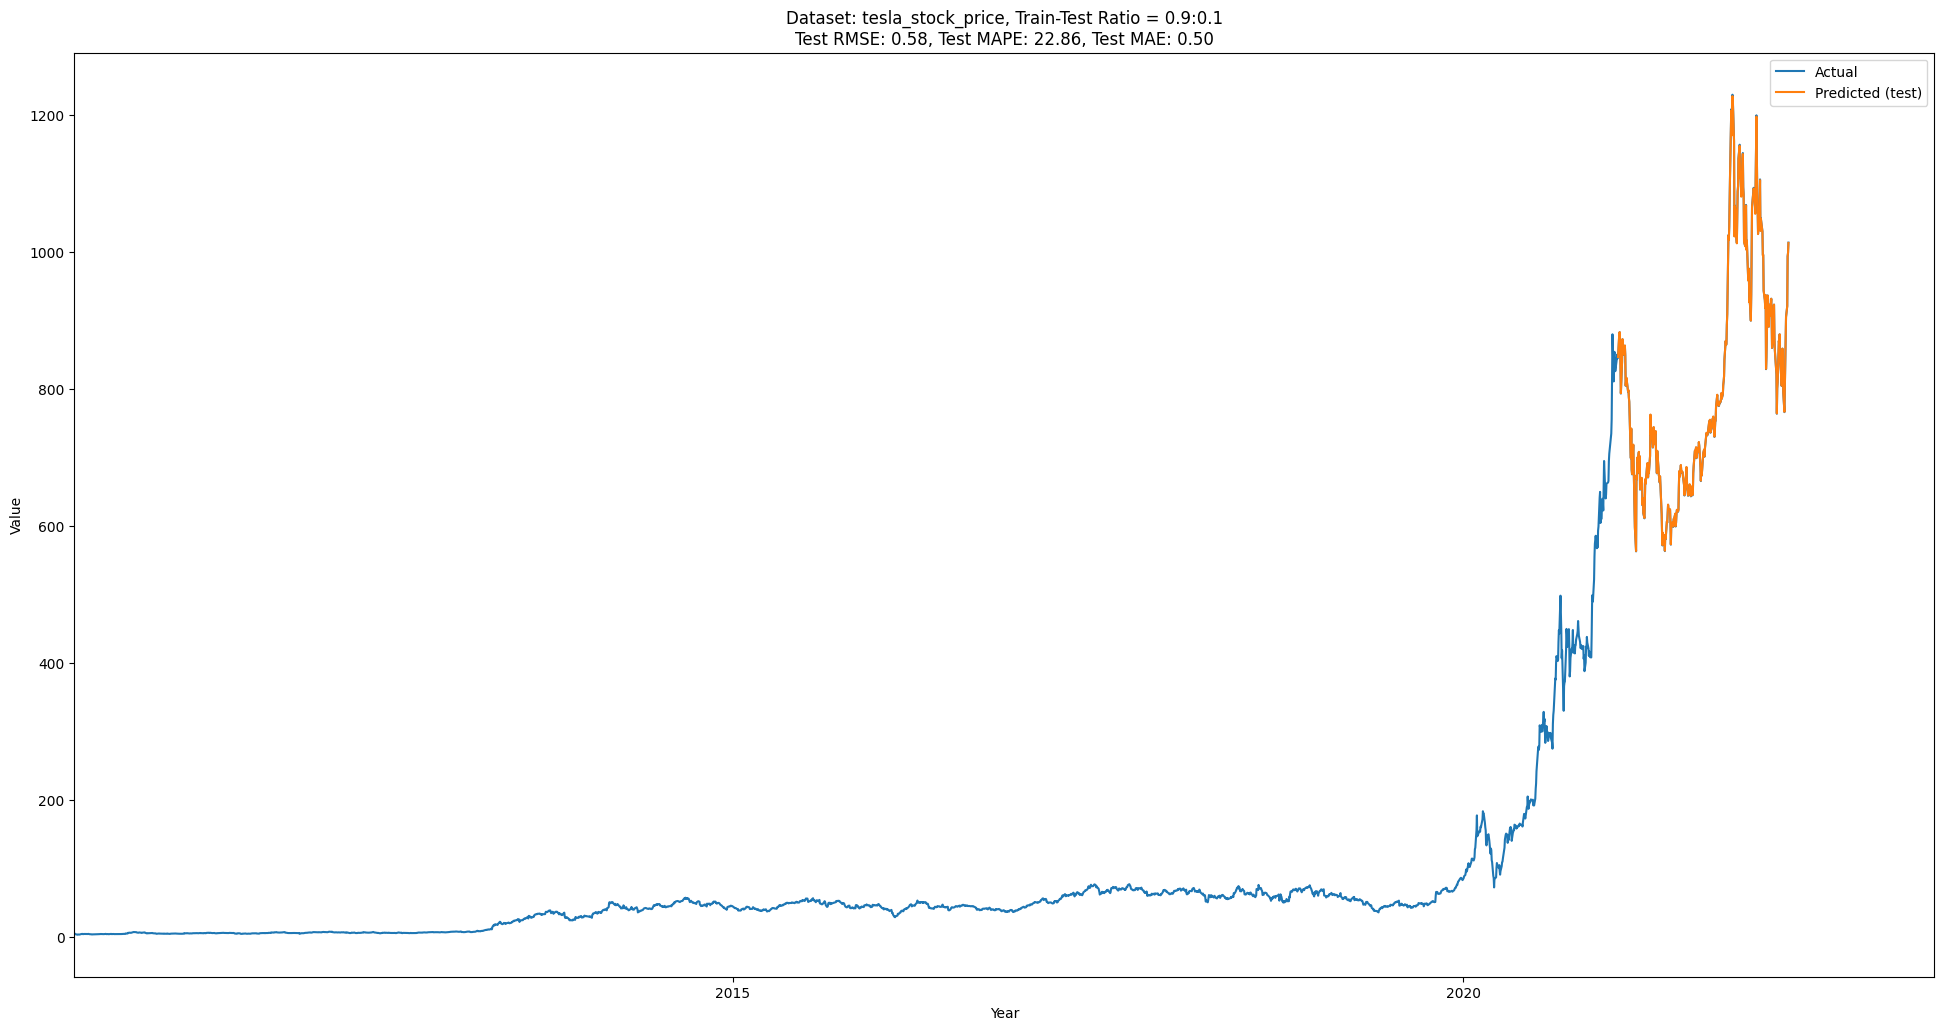

In [34]:
def train_test_model(dataset_url, train_ratio):

    # Load dataset, filter data from 2010 to 2022

    df = pd.read_csv(dataset_url, parse_dates=['Date'], index_col='Date')
    start_date = '2010-01-01'
    end_date = '2022-12-31'
    df = df.loc[start_date:end_date]

    # Split train-test data
    train_size = int(len(df) * train_ratio)
    test_size = len(df) - train_size
    train_data = df.iloc[:train_size]
    test_data = df.iloc[train_size:]

    # Normalize data
    scaler = StandardScaler()
    train_data_norm = scaler.fit_transform(train_data)
    test_data_norm = scaler.transform(test_data)

    # Build and compile the model
    inputs = Input(shape=(train_data_norm.shape[1], 1))
    conv1 = Conv1D(filters=32, kernel_size=3, padding='causal', activation='relu')(inputs)
    conv2 = Conv1D(filters=64, kernel_size=3, padding='causal', dilation_rate=2, activation='relu')(conv1)
    conv3 = Conv1D(filters=128, kernel_size=3, padding='causal', dilation_rate=4, activation='relu')(conv2)
    gap = GlobalAveragePooling1D()(conv3)
    outputs = Dense(1)(gap)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    # Train the model
    model.fit(train_data_norm.reshape(-1, train_data_norm.shape[1], 1), train_data_norm[:, -1],
              epochs=10, batch_size=32, verbose=0)

    # Make predictions on the test data
    test_pred = scaler.inverse_transform(model.predict(test_data_norm.reshape(-1, test_data_norm.shape[1], 1)))

    # Print the title for the case
    print(f"Dataset: {dataset_url.split('/')[-1].split('.')[0]}, Train-Test Ratio = {train_ratio}:{round(1 - train_ratio, 1)}")
    # Calculate evaluation metrics
    test_rmse = np.sqrt(mean_squared_error(test_data.iloc[:, -1], test_pred))
    test_mape = np.mean(np.abs((test_data.iloc[:, -1].values - test_pred) / test_data.iloc[:, -1].values)) * 100
    test_mae = mean_absolute_error(test_data.iloc[:, -1], test_pred)
    print("Root Mean Squared Error (RMSE):",  round(test_rmse,3))
    print("Mean Absolute Percentage Error (MAPE):", round(test_mape,3))
    print("Mean Absolute Error (MAE):", round(test_mae,3))

    # Plot actual vs predicted values
    df.index = pd.to_datetime(df.index)
    fig, ax = plt.subplots(figsize=(24, 12))
    plt.plot(df.index, df.iloc[:, -1].values, label='Actual')
    plt.plot(test_data.index, test_pred[:, -1], label='Predicted (test)')
    plt.title(f"Dataset: {dataset_url.split('/')[-1].split('.')[0]}, Train-Test Ratio = {train_ratio}:{round(1 - train_ratio, 1)}\n"
              f"Test RMSE: {test_rmse:.2f}, Test MAPE: {test_mape:.2f}, Test MAE: {test_mae:.2f}")
    plt.xlabel('Year')
    plt.ylabel('Value')
    plt.legend()
    plt.xlim(df.index[0], df.index[-1] + pd.DateOffset(years=1))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator(base=5))
    plt.gca().xaxis.set_major_formatter(mdates.AutoDateFormatter(mdates.YearLocator(base=5)))
    plt.show()


# Define the datasets
datasets = [
    'https://raw.githubusercontent.com/huy164/datasets/master/walmart_stock_price.csv',
    'https://raw.githubusercontent.com/huy164/datasets/master/facebook_stock_price.csv',
    'https://raw.githubusercontent.com/huy164/datasets/master/tesla_stock_price.csv'
]

# Define the train-test ratios
ratios = [0.7, 0.8, 0.9]

# Run the logic for each dataset with each ratio
for dataset_url in datasets:
    for ratio in ratios:
        train_test_model(dataset_url, ratio)
        print("\n")
